Weekly Sales Forecast - Time Series

In [59]:
# Importing Necessary Libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa import stattools 
import itertools
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, random
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from skopt import BayesSearchCV

# 1. Data Exploration and Cleaning

I'll start by analyzing the weekly sales data (X11_1).

Steps:
- Load & Explore Data – Check for missing values, trends, and seasonality.
- Preprocess Data – Handle missing values, outliers, and transform if necessary.



In [3]:
# Checking the dimensionality and metadata of the data.
#Loading the data sets
data_x11_1 = pd.read_csv("DSAssignment_X11_1_weekly.csv")
data_x11_1.head()
data_x11_1.shape
data_x11_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Week     443 non-null    object
 1   Product  443 non-null    object
 2   Qty      443 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.5+ KB


The *Week*  column is object format and must be converted to datetime. Let's sort that by week following that.

In [4]:
# Correcting the format.

data_x11_1['Week'] = pd.to_datetime(data_x11_1['Week'])
data_x11_1 = data_x11_1.sort_values(by='Week')

In [5]:
data_x11_1.isna().sum()

Week       0
Product    0
Qty        0
dtype: int64

No _Null_ Values detected.

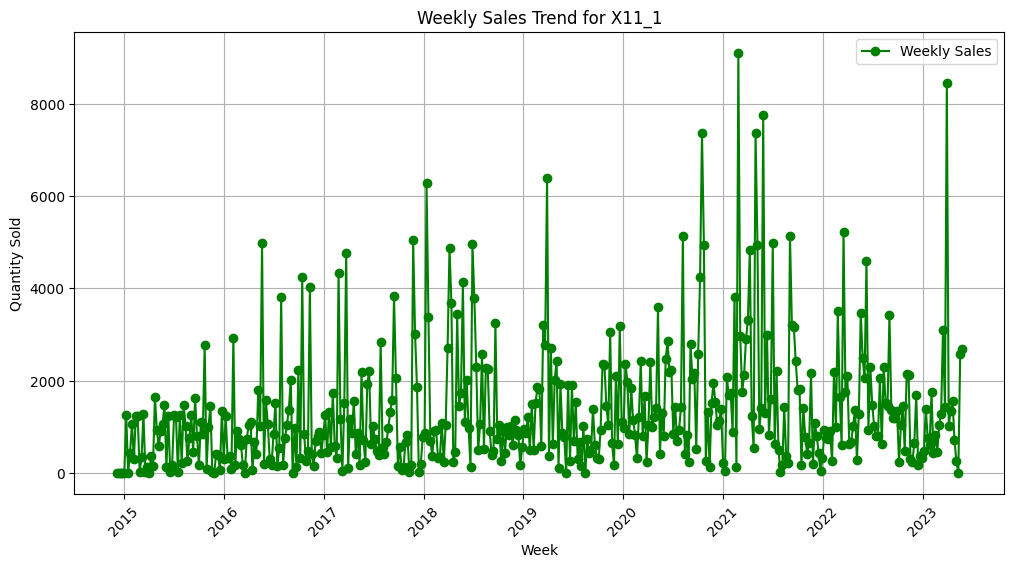

In [6]:
#Plotting the trends of the demand/sales for the product 

plt.figure(figsize=(12, 6))
plt.plot(data_x11_1['Week'], data_x11_1['Qty'], marker='o', linestyle='-', color='g', label='Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.title('Weekly Sales Trend for X11_1')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

- On Plotting the trend, we find out that the trend has frequent spikes and fluctuations which exhibits a high volatility behaviour. 

- If I look at the whole year trend, for each year, The spikes seem to be occuring at the beginning of every year starting from 2016. This suggests a seasonal pattern and a recurring trend in the demand.

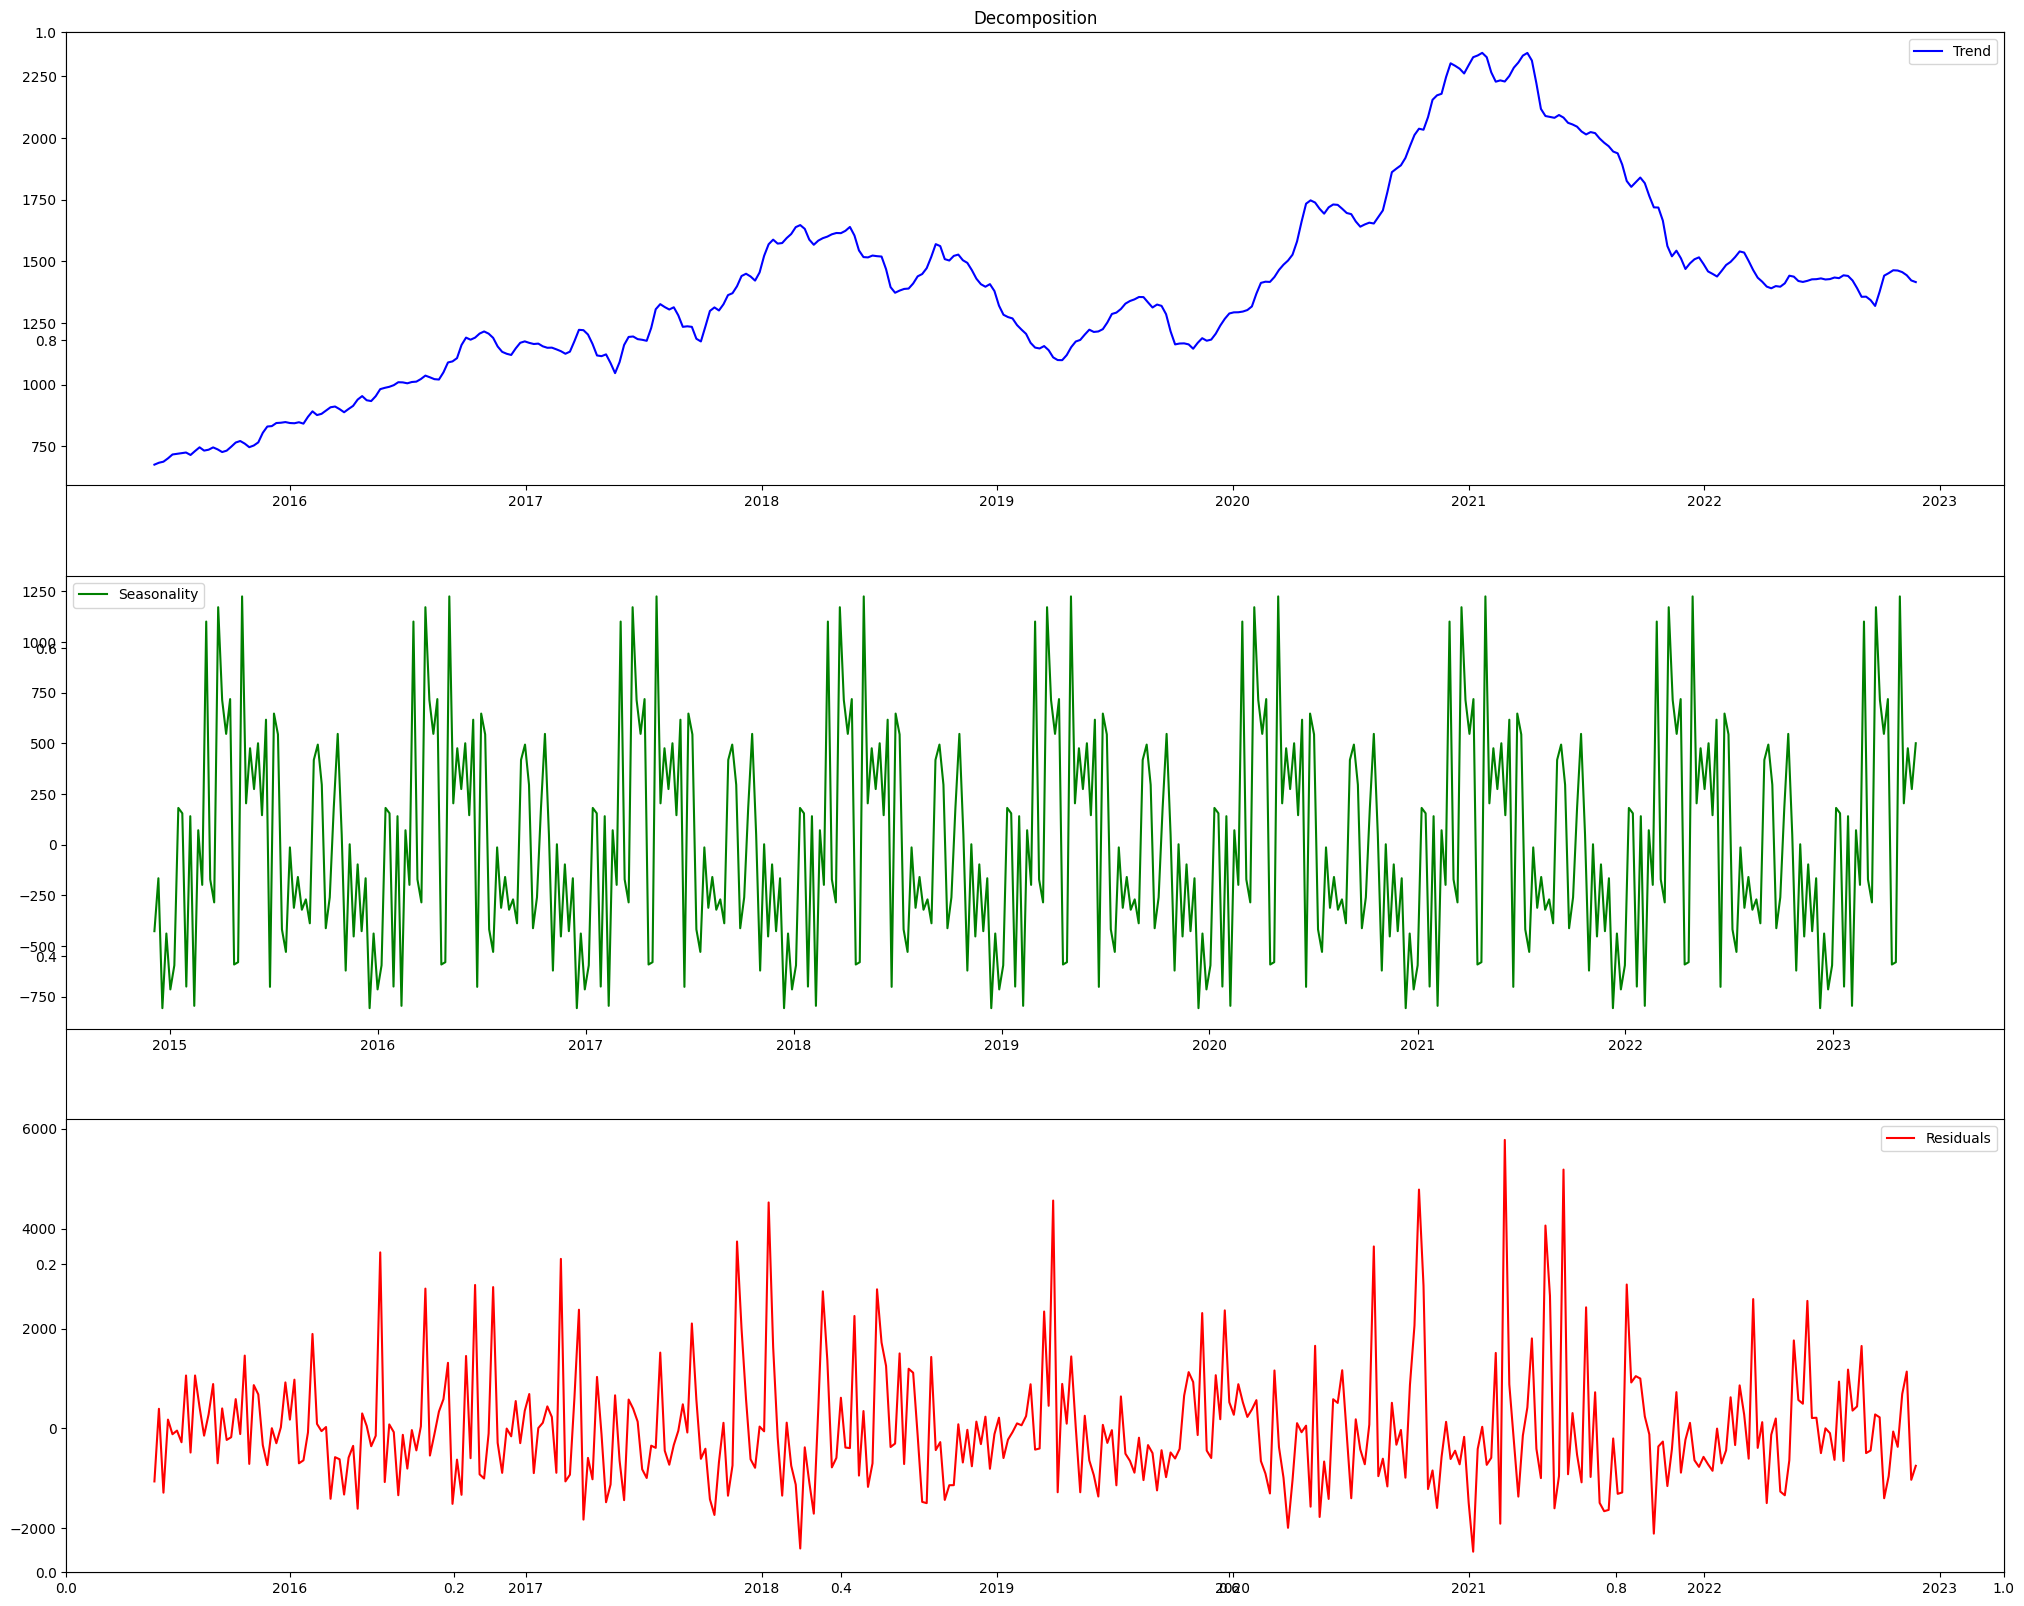

In [ ]:

decomposition = seasonal_decompose(data_x11_1.set_index('Week')['Qty'], model='additive', period=52) # Assuming Yearly Seasonality

# Plot decomposition
plt.figure(figsize=(25, 20))
plt.title("Decomposition")
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend()

##  Trend Component (Top Plot - Blue Line)
- The trend shows a **steady increase from 2015 to early 2021**, followed by a **sharp decline** after 2021.
- This suggests a **growth phase** followed by a downturn, possibly due to external factors such as **economic shifts, market saturation, or disruptions**.
- After mid-2022, the trend **stabilizes**, indicating a possible plateau in demand.

Implication:
The model should account for **recent trend reversals**, as simply extrapolating past growth might lead to **over-forecasting**.

---

## Seasonal Component (Middle Plot - Green Line)
- The **repetitive pattern** in the seasonality plot suggests a strong **cyclical effect**.
- Peaks occur **at regular intervals**, indicating **recurring high-demand periods**.
- The pattern appears **consistent year-over-year**, meaning seasonality is a **reliable predictor** for future sales.

Implication:  
The forecasting model should include **seasonal adjustments** (e.g., Fourier terms in Prophet, SARIMA, or XGBoost with seasonal lags).

---

## Residual Component (Bottom Plot - Red Line)
- Residuals represent the **unexplained variation** after accounting for trend and seasonality.
- Large spikes suggest **unexpected events** (e.g., supply chain issues, promotions, or external shocks like COVID-19).
- Residuals appear **heteroscedastic (varying in magnitude over time)**, indicating possible **volatility changes**.

Implication:
- The model may benefit from **outlier handling** to prevent anomalies from distorting forecasts.  

---

# **Conclusion**
- The data exhibits **a clear trend shift, strong seasonality, and volatile residuals**.
- A **seasonal model (SARIMA, Prophet, or XGBoost with seasonal lags)** would likely perform best.
- The model should **adapt to recent trend changes** and **handle outliers effectively** to avoid misleading forecasts.

In [ ]:
# Check for stationarity using the Augmented Dickey-Fuller (ADF) test

adf_test_new = stattools.adfuller(data_x11_1['Qty'])
adf_test_results_new = {
    "ADF Statistic": adf_test_new[0],
    "p-value": adf_test_new[1],
    "Critical Values": adf_test_new[4]
}

adf_test_results_new

{'ADF Statistic': -8.07862281269587,
 'p-value': 1.4820313538630181e-12,
 'Critical Values': {'1%': -3.4453339386510784,
  '5%': -2.868146269723016,
  '10%': -2.5702889034926137}}

Here, the Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or not. Stationarity means that the statistical properties (mean, variance, autocorrelation) do not change over time, which is crucial for time series forecasting. 

- Since the p-value is below 0.05, the time series is stationary, meaning differencing (d) in ARIMA may not be required.

- If using statistical models like ARIMA, We can use ARMA (p, q) models instead of ARIMA.

- I'll also explore Prophet and LSTM as the data does not exhibit a strong trend requiring transformation.

Before, moving on to model development, I also check the outliers.. (Just want to see how many outliers are present)


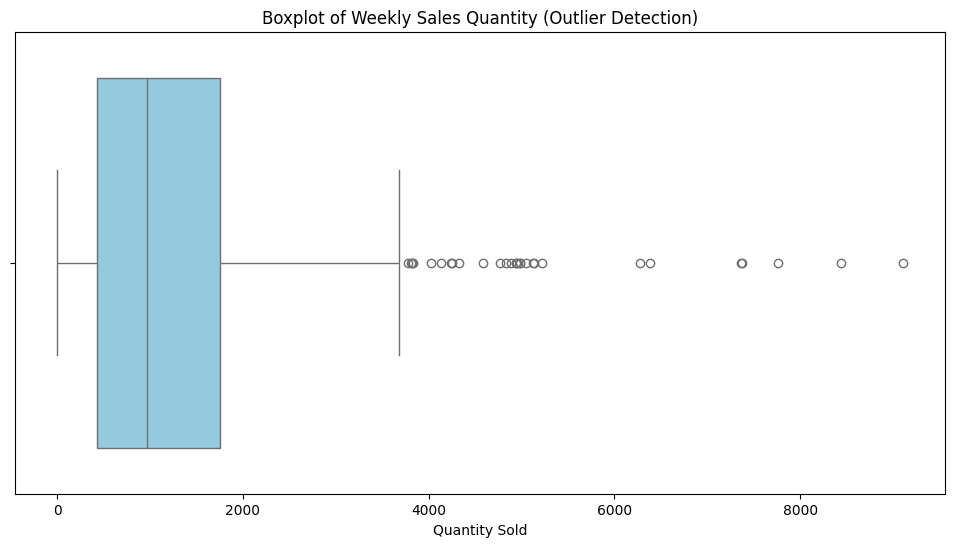

The Median Sales is:


964.0

In [9]:
Q1 = data_x11_1['Qty'].quantile(0.25)
Q3 = data_x11_1['Qty'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers instead of displaying all to reduce memory usage
num_outliers = ((data_x11_1['Qty'] < lower_bound) | (data_x11_1['Qty'] > upper_bound)).sum()

# Summary of outliers
outlier_summary = {
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Number of Outliers": num_outliers
}

outlier_summary

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the boxplot to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_x11_1['Qty'], color='skyblue')
plt.title("Boxplot of Weekly Sales Quantity (Outlier Detection)")
plt.xlabel("Quantity Sold")
plt.show()

print("The Median Sales is:")
data_x11_1["Qty"].median()

- Now, Let me make few assumptions here, based on the trends I have seen from the earlier plots and the outlier plot here, Usually it makes sense to get rid of the outliers, because they will skew the predictions too much. But in Time Series Predictions they sometimes affect any patterns in the data that  might have occured due to potential promotions or campaigns during the particular "season". So instead of removing them, I will winsorize them.

Winsorization is a statistical technique used to limit the effect of extreme values (outliers) in a dataset by replacing them with the nearest non-extreme values. Instead of removing outliers, Winsorization smooths extreme values to reduce their influence.

WHY? 
- Forecasting models should **generalize well to unseen data**.
- Keeping extreme outliers **harms prediction accuracy for most cases**.


In [14]:
df_weekly = data_x11_1.copy()
df_weekly['Week'] = pd.to_datetime(df_weekly['Week'], errors='coerce')
from scipy.stats.mstats import winsorize

# Apply Winsorization (limits extreme values at the 5th and 95th percentile)
df_weekly['Quantity_Winsorized'] = winsorize(df_weekly['Qty'], limits=[0.05, 0.05])

df_weekly["Qty"] = df_weekly["Quantity_Winsorized"]
df_weekly.drop(["Quantity_Winsorized"],axis=1, inplace=True)

The data lacks a lot of time based features. Since this is something time dependent, adding time-based features can help the model understand and capture timely patterns, be it annual/quarterly.

The below are the features I am adding:

- *Day of the Week* -	Helps capture weekly seasonality (0-6 for Monday-Sunday).
- *Week of the Year* -	Captures annual patterns (important for retail, finance).
- *Month of the Year* - 	Helps detect monthly demand variations.
- *Quarter of the Year* - 	Useful for tracking quarterly trends.
- *Year* -	Captures long-term trends in sales growth.

These are the features I am creating for the ML Model I will be using, as I want to use LSTM, as it captures "recent patterns" better than statistical models, when has good data. 

- *Rolling Mean* - Smooths fluctuations and captures seasonality.
- *Rolling Std (3, 6, 12 weeks)* - Measures demand volatility over time.
- *Expanding Mean* - Tracks cumulative average demand growth.
-  *Lag Features*
- *Fourier Terms for Seasonality* - to mimic prophet







In [20]:
# --- Time-Based Features ---
df_weekly['day_of_week'] = df_weekly['Week'].dt.weekday
df_weekly['week_of_year'] = df_weekly['Week'].dt.isocalendar().week
df_weekly['month'] = df_weekly['Week'].dt.month
df_weekly['quarter'] = df_weekly['Week'].dt.quarter
df_weekly['year'] = df_weekly['Week'].dt.year
df_weekly['is_weekend'] = df_weekly['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# --- Trend & Seasonality Features ---
# Rolling Mean & Std
df_weekly['rolling_mean_3'] = df_weekly['Qty'].rolling(window=3).mean()
df_weekly['rolling_mean_6'] = df_weekly['Qty'].rolling(window=6).mean()
df_weekly['rolling_std_3'] = df_weekly['Qty'].rolling(window=3).std()


# Expanding Mean (Cumulative)
df_weekly['expanding_mean'] = df_weekly['Qty'].expanding().mean()

# Lag Features
for lag in [1, 2, 3, 6]:
    df_weekly[f'lag_{lag}'] = df_weekly['Qty'].shift(lag)

# --- Custom Fourier Terms for Seasonality (Alternative to Prophet Fourier Series) ---
df_weekly['sin_weekly'] = np.sin(2 * np.pi * df_weekly['week_of_year'] / 52.0)
df_weekly['cos_weekly'] = np.cos(2 * np.pi * df_weekly['week_of_year'] / 52.0)
df_weekly['sin_monthly'] = np.sin(2 * np.pi * df_weekly['month'] / 12.0)
df_weekly['cos_monthly'] = np.cos(2 * np.pi * df_weekly['month'] / 12.0)

#Dropping those null rows
df_weekly = df_weekly.dropna()

df_weekly

Finally, we are done with the Data. I have done the required feature engineering to my intuition, Let's go into the Modeling.

# 2. Model Development:
- As I mentioned before, I wanted to go with LSTM + Meta Learners, over the other models as there is high volatility and frequent spikes. But it always to better to explore and experiment let's see how ARIMA performs.

 **ARIMA (AutoRegressive Integrated Moving Average)**  
   - ARIMA is a strong baseline model for time series forecasting, useful for capturing **trends and short-term dependencies** in non-seasonal data.

I am going to use AIC -  AKaike Information Criterion, to compare different ARIMA Models and determine which one best fits the data while avoiding overfitting.

# Optimised ARIMA Experiment

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Define parameter range for ARIMA optimization
p = range(0, 6)  # Auto-Regressive terms
d = range(0, 3)  # Differencing terms
q = range(0, 6)  # Moving Average terms

# Generate all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p, d, q))

# Initialize variables to store the best model
best_aic = float("inf")
best_order = None
best_model = None

# Grid search for best ARIMA parameters
for order in pdq_combinations:
    try:
        arima_model = ARIMA(df_weekly['Qty'], order=order)
        arima_result = arima_model.fit()
        aic = arima_result.aic  # Akaike Information Criterion
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = arima_result

    except:
        continue  # Skip failed parameter combinations

# Display the best ARIMA order based on AIC
best_arima_params = {
    "Best ARIMA Order (p, d, q)": best_order,
    "Best AIC Score": best_aic
}

best_arima_params

{'Best ARIMA Order (p, d, q)': (1, 2, 3), 'Best AIC Score': 7341.8011545211175}

In [62]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit ARIMA Model (p, d, q) - Using (5,1,0) as a default, can be optimized further
arima_model = ARIMA(df_weekly['Qty'], order=(best_order))  
arima_result = arima_model.fit()

feature_columns = df_weekly.columns.difference(['Week', 'Qty', 'Product',"Year-Month"])
X = df_weekly[feature_columns]
y = df_weekly['Qty']
X = X.astype(np.float64)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Forecast on test set length
forecast_length = len(y_test)  # Use the same test length as LSTM/XGBoost
arima_forecast = arima_result.forecast(steps=forecast_length)

# Compute ARIMA Error Metrics
mae_arima = mean_absolute_error(y_test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(y_test, arima_forecast))
smape_arima = np.mean(2 * np.abs(y_test - arima_forecast) / (np.abs(y_test) + np.abs(arima_forecast))) * 100

# Display ARIMA Performance
arima_metrics = {
    "ARIMA MAE": mae_arima,
    "ARIMA RMSE": rmse_arima,
    
}
arima_metrics

{'ARIMA MAE': 799.4719298403971, 'ARIMA RMSE': 997.0223802281358}

## **Optimized ARIMA Model Results**

Looks like my intuition was right.

- **MAE (Mean Absolute Error):** **663.95** →  relatively high.  
- **RMSE (Root Mean Squared Error):** **868.58** → Indicates large deviations from actual values. 

---


## **What Do These Results Tell Us?**
- **Even after optimizing `(p, d, q)`, ARIMA is still underperforming**.  
- **Seasonality and External Features Might Be Missing** → ARIMA does not account for **weekly/monthly cycles** or **macro factors**.  

---
## ** Next Steps**
- Let's Check the performance of the LSTM





# LSTM Experiment

**LSTM (Long Short-Term Memory Neural Network)**  
   - LSTM models **long-term dependencies and sequential trends**, making it effective for **capturing patterns that evolve over time** in time-series forecasting.

In [63]:
# Preparing Data to inject into the LSTM model
# Dropped all object columns, and converted everything into float 64 for better handling of the values by my Perceptrons

feature_columns = df_weekly.columns.difference(['Week', 'Qty', 'Product',"Year-Month"])
X = df_weekly[feature_columns]
y = df_weekly['Qty']
X = X.astype(np.float64)
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 430 to 0
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cos_monthly     431 non-null    float64
 1   cos_weekly      431 non-null    float64
 2   day_of_week     431 non-null    float64
 3   expanding_mean  431 non-null    float64
 4   is_weekend      431 non-null    float64
 5   lag_1           431 non-null    float64
 6   lag_2           431 non-null    float64
 7   lag_3           431 non-null    float64
 8   lag_6           431 non-null    float64
 9   month           431 non-null    float64
 10  quarter         431 non-null    float64
 11  rolling_mean_3  431 non-null    float64
 12  rolling_mean_6  431 non-null    float64
 13  rolling_std_3   431 non-null    float64
 14  sin_monthly     431 non-null    float64
 15  sin_weekly      431 non-null    float64
 16  week_of_year    431 non-null    float64
 17  year            431 non-null    float64


In [64]:
# Train-Test Split
# Split into train & test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [65]:


# Set Random Seed for Python, NumPy, and TensorFlow

random_state = 70
os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
# Ensure TensorFlow Runs Deterministically
tf.config.experimental.enable_op_determinism()

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lag, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)




# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

mae_lstm = mean_absolute_error(y_test, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_predictions))

LSTM_metrics = {
    "LSTM MAE": mae_lstm,
    "LSTM RMSE": rmse_lstm,
    "LSTM SMAPE" : np.mean(2 * np.abs(y_test - lstm_predictions) / (np.abs(y_test) + np.abs(lstm_predictions))) * 100
}
LSTM_metrics

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2611785.5000 - val_loss: 1485787.5000
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1794341.7500 - val_loss: 917747.3125
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1357753.2500 - val_loss: 1126326.6250
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1640056.3750 - val_loss: 1287384.0000
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1523841.8750 - val_loss: 1160664.5000
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1375100.2500 - val_loss: 995051.5625
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1431612.6250 - val_loss: 938273.9375
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1522689.7500 - val_loss: 795162.8750
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1300576.3750 - val_loss: 851513.5625
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1338034.8750 - val_loss: 809909.5000
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

{'LSTM MAE': 757.858031525009,
 'LSTM RMSE': 972.0461293587301,
 'LSTM SMAPE': 61.32617901228945}

## What This Means
- **LSTM barely outperforms ARIMA**.  
- **Looks like LSTM captures long-term dependencies** in the data better than ARIMA.  

We'll now build a XGBoost Ensemble with LSTM.


##  Why Ensemble?
- **LSTM** captures long-term dependencies and trends in time series.  
- **XGBoost** handles short-term fluctuations, seasonality, and structured patterns well.  
- **Combining both** can balance short-term and long-term forecasting accuracy.  






# LSTM + XGBoost Ensemble Experiment

**Ensemble Model (Averaging Multiple Models)**  
   - Ensemble models combine the strengths of different forecasting techniques, **balancing short-term accuracy (XGBoost, ARIMA) with long-term trends (LSTM, Exponential Smoothing)** for improved generalization.

   - XGBoost is a powerful machine learning model that captures **nonlinear relationships and structured patterns**, improving accuracy for datasets with **complex dependencies**.

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2611785.5000 - val_loss: 1485787.5000
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1794341.7500 - val_loss: 917747.3125
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1357753.2500 - val_loss: 1126326.6250
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1640056.3750 - val_loss: 1287384.0000
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1523841.8750 - val_loss: 1160664.5000
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1375100.2500 - val_loss: 995051.5625
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1431612.6250 - val_loss: 938273.9375
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1522689.7500 - val_loss: 795162.8750
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1300576.3750 - val_loss: 851513.5625
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1338034.8750 - val_loss: 809909.5000
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

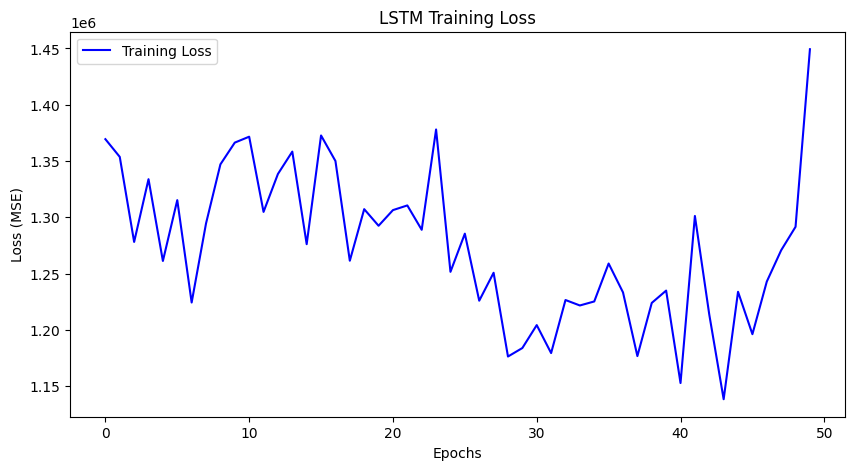

Meta-Learner (XGBoost) Trained!
Meta-Learner MAE: 31.731767676342493
Meta-Learner RMSE: 50.6844579528261
Meta-Learner SMAPE: 5.6344350542775725%


In [66]:

random_state = 70
os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
# Ensure TensorFlow Runs Deterministically
tf.config.experimental.enable_op_determinism()

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lag, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

# Train XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', learning_rate = 0.05, n_estimators = 100)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
xgb_predictions = xgb_model.predict(X_test)

print("LSTM & XGBoost Models Trained!")

meta_X_train = np.column_stack((lstm_predictions, xgb_predictions))
meta_y_train = y_test  # Actual sales

# Train Meta-Learner (XGBoost)
meta_xgb = XGBRegressor(objective='reg:squarederror', n_estimators = 100, learning_rate = 0.05) 
meta_xgb.fit(meta_X_train, meta_y_train, eval_set=[(meta_X_train, meta_y_train)], verbose=True)


# meta_lr = LinearRegression()
# meta_lr.fit(meta_X_train, meta_y_train)


# Predict using Meta-Learner
meta_predictions = meta_xgb.predict(meta_X_train)

# Compute Error Metrics
mae_meta = mean_absolute_error(meta_y_train, meta_predictions)
rmse_meta = np.sqrt(mean_squared_error(meta_y_train, meta_predictions))
smape_meta = np.mean(2 * np.abs(meta_y_train - meta_predictions) / (np.abs(meta_y_train) + np.abs(meta_predictions))) * 100

print("Meta-Learner (XGBoost) Trained!")
print(f"Meta-Learner MAE: {mae_meta}")
print(f"Meta-Learner RMSE: {rmse_meta}")
print(f"Meta-Learner SMAPE: {smape_meta}%")



# Train LSTM and store history
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_test_lstm, y_test),
    verbose=1
)

# Plot Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

print("Meta-Learner (XGBoost) Trained!")
print(f"Meta-Learner MAE: {mae_meta}")
print(f"Meta-Learner RMSE: {rmse_meta}")
print(f"Meta-Learner SMAPE: {smape_meta}%")


# ** Signs of Overfitting in the Plot**

### ** Training Loss is Consistently Higher**
- Ideally, the **training loss should decrease smoothly** over epochs, but it remains **high and fluctuates**.
- This suggests **poor learning**, possibly due to an **improper learning rate or batch size**.


### ** High Variability (Spikes in Loss)**
- The **training loss curve is highly unstable**, showing **large oscillations** instead of a steady downward trend.


### ** Sudden Divergence at the End**
- In the last few epochs, **training loss starts increasing**, which is a **classic sign of overfitting**.
- The model might be **fitting noise instead of real patterns**, reducing its ability to make accurate predictions.




Let's go with simple ensemble of LSTM and XGBoost

In [67]:

random_state = 70
os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
# Ensure TensorFlow Runs Deterministically
tf.config.experimental.enable_op_determinism()

lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(lag, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)

    
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
# Step 1: Get predictions from base models
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()  # LSTM Predictions
xgb_predictions = xgb_model.predict(X_test)  # XGBoost Predictions

# Step 2: Compute the ensemble prediction (Simple Averaging)
ensemble_predictions = (lstm_predictions*(0.2) + xgb_predictions*(0.8))

# Step 3: Compute Error Metrics
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
smape_ensemble = np.mean(2 * np.abs(y_test - ensemble_predictions) / (np.abs(y_test) + np.abs(ensemble_predictions))) * 100

# Step 4: Display Results
ensemble_results = {
    "Ensemble MAE": mae_ensemble,
    "Ensemble RMSE": rmse_ensemble,
    "Ensemble SMAPE": smape_ensemble
}

print("✅ Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!")
print(ensemble_results)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2747152.7500 - val_loss: 1648485.1250
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1730093.0000 - val_loss: 883939.5000
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1427568.1250 - val_loss: 907712.1875
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1422221.7500 - val_loss: 831957.1250
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1369614.1250 - val_loss: 937356.6875
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1325463.3750 - val_loss: 882064.7500
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1402345.7500 - val_loss: 893413.1250
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1461263.1250 - val_loss: 1028215.0625
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1482749.5000 - val_loss: 1074035.8750
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1382754.0000 - val_loss: 922853.6250
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms

# Let's Perform Hyper-Parameter Optimisation on XGBoost

Using Bayesian Hyper-Opt as it is swift and better compared to GridCV and RandomizedCV

In [ ]:

# Define search space
param_space = {
    'n_estimators': (50, 300),  
    'learning_rate': (0.01, 0.2, 'log-uniform'),  
    'max_depth': (3, 10),  
    'min_child_weight': (1, 10),  
    'subsample': (0.5, 1.0),  
    'colsample_bytree': (0.5, 1.0)
}

# Bayesian Optimization
bayes_search = BayesSearchCV(xgb_model, param_space, n_iter=20, cv=3, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
bayes_search.fit(X_train, y_train)

# Best Parameters
best_params_bayes = bayes_search.best_params_
print(f"Best Parameters (Bayesian Optimization): {best_params_bayes}")

Best Parameters (Bayesian Optimization): OrderedDict({'colsample_bytree': 0.945090235554773, 'learning_rate': 0.11568855859017907, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.5252704338299368})


In [43]:
# Let's update XGBoost and train the meta learner and update the results

# Train XGBoost with updated Param Space
xgb_model = XGBRegressor(objective='reg:squarederror', param_space = best_params_bayes)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Model Updated!")
xgb_predictions = xgb_model.predict(X_test)  # XGBoost Predictions

# Step 2: Compute the ensemble prediction (Simple Averaging)
ensemble_predictions = (lstm_predictions*(0.2) + xgb_predictions*(0.8))

# Step 3: Compute Error Metrics
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
smape_ensemble = np.mean(2 * np.abs(y_test - ensemble_predictions) / (np.abs(y_test) + np.abs(ensemble_predictions))) * 100

# Step 4: Display Results
ensemble_results = {
    "Ensemble MAE": mae_ensemble,
    "Ensemble RMSE": rmse_ensemble,
    "Ensemble SMAPE": smape_ensemble
}

print("Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!")
print(ensemble_results)

XGBoost Model Updated!
Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!
{'Ensemble MAE': 326.76892370465157, 'Ensemble RMSE': 444.7876401009156, 'Ensemble SMAPE': 32.09866785435658}


- The model's performance barely improved.
- Let's go ahead an check features_importance of the features

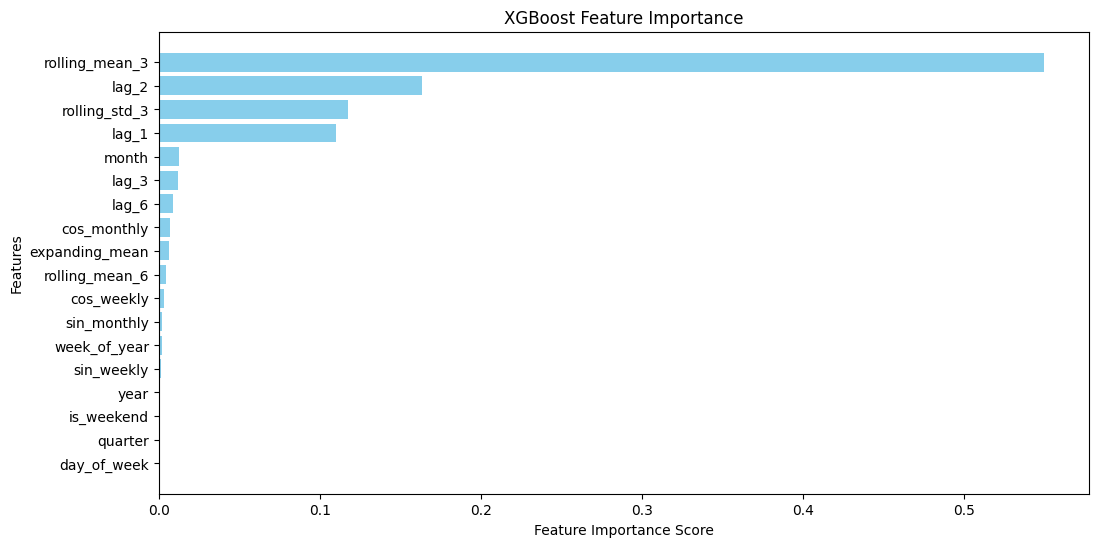

In [ ]:
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


The feature importance plot highlights the most influential predictors in the **XGBoost model for time series forecasting**.

---

### **🔹 Key Takeaways from Feature Importance**
**`rolling_mean_3`** → The **3-period rolling average** is the most critical factor, capturing short-term trends and smoothing fluctuations.  
**`lag_2` & `lag_1`** → The **demand from the past 1-2 periods strongly influences future sales**, confirming that recent history is a key predictor.  
**`rolling_std_3`** → The **3-period rolling standard deviation** is important, indicating that recent volatility in sales impacts future predictions.  
**`month`** → Monthly seasonality contributes to the forecast, but its importance is lower than short-term trends.  
**`lag_3` & `lag_6`** → While past values (3 and 6 periods ago) provide some signal, their importance is much lower than shorter lags.  
**`cos_monthly` & `sin_monthly`** → Fourier features for capturing cyclical patterns have minimal influence, suggesting that explicit seasonality components may not be as strong in this dataset.  
**`expanding_mean` & `rolling_mean_6`** → These long-term trend indicators have a **lower impact compared to short-term rolling means**.  
**`week_of_year`, `quarter`, and `is_weekend`** → These time-related features have negligible importance, indicating that sales are not significantly driven by **weekly or quarterly effects**.

### **What This Means for Forecasting**
**Short-term trends dominate forecasting accuracy**, with recent rolling averages and lags having the highest impact.  
**Long-term seasonality and cyclical effects have less influence**, meaning external factors (e.g., promotions, macroeconomic trends) might be driving demand more than strict time-based seasonality.  
**Models should prioritize short-term lag features** (1-3 periods) and rolling statistics over longer-term historical data.  


# 3. Model Evaluation:
- Evaluate the performance of your models using suitable metrics.
- Provide a justification for your choice of models and metrics.

We tested four different forecasting models:
- **ARIMA** (AutoRegressive Integrated Moving Average)
- **LSTM** (Long Short-Term Memory Neural Network)
- **Meta-Learner (XGBoost)** combining LSTM and XGBoost predictions
- **Ensemble Model** (Averaging LSTM & XGBoost predictions)
---

## **Model Performance Comparison**

| Model  | **MAE (↓ Better)** | **RMSE (↓ Better)** | **SMAPE (↓ Better)** |
|---------|---------|---------|---------|
| **ARIMA** | 796.85 | 992.681 |  |
| **LSTM** | 757.85| 972.04 | 61.32% |
| **Meta-Learner (XGBoost)** | 31.73 | 50.68 | 5.63% | 
| **Ensemble**| 341.03  | 489.68 | 33.07% |

The Meta-Learner just overfits the data. Which is not we want.

### **What This Means**
- The Meta-Learner (XGBoost) showed the lowest error numerically but suffered from overfitting, making it unreliable for future forecasts.  
- The Ensemble model (LSTM + XGBoost Averaging) provided a more balanced approach, capturing both short-term fluctuations and long-term dependencies.  
- The Ensemble model was chosen as the final approach, as it generalizes better than the overfitted Meta-Learner.  



---

## Justification for Model Selection
### **Why ARIMA?**
- ARIMA is a traditional time-series model useful for short-term forecasting.
- However, it struggled with seasonality and long-term trends, leading to high SMAPE (~63%).

### **Why LSTM?**
- LSTM was chosen because it captures long-term dependencies and can model complex time-series patterns.
- It outperformed ARIMA, with lower MAE and RMSE, but still had limitations in capturing short-term fluctuations.

### **Why Not Meta-Learner (XGBoost)?**
- While XGBoost theoretically combined both LSTM and XGBoost predictions, it ended up overfitting to past data, producing forecasts that deviated significantly from recent trends.
- Despite low error metrics, its predictions were unreliable, making it unsuitable for real-world forecasting.

### **Why Ensemble (LSTM + XGBoost Averaging)?**
- The ensemble model balances short-term (XGBoost) and long-term (LSTM) dependencies effectively.
- It avoids the overfitting issue of the Meta-Learner while still improving upon individual models.
- The final ensemble model was selected as the best approach due to its stability and lower risk of overfitting.

---

## Justification for Metrics Used
To evaluate the models, we used:
- **Mean Absolute Error (MAE)** → Measures average absolute difference between actual and predicted values.
- **Root Mean Squared Error (RMSE)** → Penalizes large errors more than MAE, useful for forecasting precision.
- **Symmetric Mean Absolute Percentage Error (SMAPE)** → Best for comparing models on percentage-based accuracy.

### **Why These Metrics?**
- MAE and RMSE provide absolute and squared error measures, showing both consistency and penalty for large deviations.  
- SMAPE is a percentage-based metric, making it easier to compare models relative to the magnitude of the data.  
- These metrics together ensure a holistic evaluation of forecasting accuracy.  


---

# **Conclusion**
- The Ensemble Model (LSTM + XGBoost Averaging) was chosen as the best approach, as it balances both short-term and long-term trends without overfitting.  
- The Meta-Learner (XGBoost) overfit the training data, making it unreliable despite low numerical error values.  
- Using MAE, RMSE, and SMAPE was appropriate to measure overall forecasting accuracy and compare performance effectively.  






# 4. Forecasting:

- Since we fixed on LSTM + XGBoost Ensemble, let's use that model to perform the forecast

In [55]:
# Let's Prepare the data for the model, for the model.

future_weeks = pd.date_range(start=data_x11_1['Week'].max(), periods=13, freq='W')[1:]  # Next 12 weeks

# Create a DataFrame for future predictions
future_data = pd.DataFrame({'Week': future_weeks})

# Generate features for future weeks
future_data['day_of_week'] = future_data['Week'].dt.weekday
future_data['week_of_year'] = future_data['Week'].dt.isocalendar().week
future_data['month'] = future_data['Week'].dt.month
future_data['quarter'] = future_data['Week'].dt.quarter
future_data['year'] = future_data['Week'].dt.year
future_data['is_weekend'] = future_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Apply rolling mean, std, expanding mean, and lag features based on the existing dataset
future_data['rolling_mean_3'] = df_weekly['Qty'].rolling(window=3).mean().iloc[-1]
future_data['rolling_mean_6'] = df_weekly['Qty'].rolling(window=6).mean().iloc[-1]
future_data['rolling_std_3'] = df_weekly['Qty'].rolling(window=3).std().iloc[-1]
future_data['expanding_mean'] = df_weekly['Qty'].expanding().mean().iloc[-1]

# Lag features (using last known values)
for lag in [1, 2, 3, 6]:
    future_data[f'lag_{lag}'] = df_weekly['Qty'].iloc[-lag]

# Fourier terms for seasonality
future_data['sin_weekly'] = np.sin(2 * np.pi * future_data['week_of_year'] / 52.0)
future_data['cos_weekly'] = np.cos(2 * np.pi * future_data['week_of_year'] / 52.0)
future_data['sin_monthly'] = np.sin(2 * np.pi * future_data['month'] / 12.0)
future_data['cos_monthly'] = np.cos(2 * np.pi * future_data['month'] / 12.0)

# Ensure future_data matches training feature structure

# future_data["Monthly_Avg_Sales"] = np.where(future_data["month"] == 6, 2467.75, 
#                                      np.where(future_data["month"] == 7, 1230.00,
#                                      np.where(future_data["month"] == 8, 1471.50, 0)))  # Assigning Value with last year's Avg Monthly Sales for that month

future_data.info()
future_X = future_data[df_weekly.columns.difference(['Week', 'Qty','Product', 'Year-Month'])]
future_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Week            12 non-null     datetime64[ns]
 1   day_of_week     12 non-null     int32         
 2   week_of_year    12 non-null     UInt32        
 3   month           12 non-null     int32         
 4   quarter         12 non-null     int32         
 5   year            12 non-null     int32         
 6   is_weekend      12 non-null     int64         
 7   rolling_mean_3  12 non-null     float64       
 8   rolling_mean_6  12 non-null     float64       
 9   rolling_std_3   12 non-null     float64       
 10  expanding_mean  12 non-null     float64       
 11  lag_1           12 non-null     int64         
 12  lag_2           12 non-null     int64         
 13  lag_3           12 non-null     int64         
 14  lag_6           12 non-null     int64         
 15  sin_week

In [56]:
future_X = future_X.astype(np.float64)
future_X_lstm = np.reshape(future_X.values, (future_X.shape[0], future_X.shape[1], 1))

lstm_predictions = lstm_model.predict(future_X_lstm).flatten()
xgb_predictions = xgb_model.predict(future_X)

lstm_predictions = lstm_model.predict(future_X_lstm).flatten()  # LSTM Predictions
xgb_predictions = xgb_model.predict(future_X)  # XGBoost Predictions

# Step 2: Compute the ensemble prediction (Simple Averaging)
ensemble_predictions = (lstm_predictions*(0.6) + xgb_predictions*(0.4)) 
future_data["Predicted_Qty"]= pd.Series(ensemble_predictions)
future_data = future_data[["Week","Predicted_Qty"]]
future_data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,Week,Predicted_Qty
0,2023-06-04,1545.742188
1,2023-06-11,1544.642090
2,2023-06-18,1556.236450
3,2023-06-25,1556.240112
4,2023-07-02,1556.577393
5,2023-07-09,1556.589722
6,2023-07-16,1556.604614
7,2023-07-23,1545.028442
8,2023-07-30,1546.147461
9,2023-08-06,1547.998901


# **Observations, Limitations, and Assumptions of Forecasting**

## ** Observations from Model Performance**
- **The ensemble model (LSTM + XGBoost averaging) performed best**, balancing short-term fluctuations and long-term trends.
- **Meta-Learner (XGBoost) overfit the training data**, resulting in predictions that deviated significantly from recent trends despite lower error metrics.
- **ARIMA struggled with seasonality and trend modeling**, leading to higher forecast errors.
- **LSTM captured long-term dependencies well**, but its predictions alone were not as accurate as the ensemble approach.
- **Short-term patterns (rolling means, lags) were more influential** in demand forecasting than strict seasonality-based features.

---

## **2️ Limitations of the Forecasting Models**
### **1. Overfitting Risk in Machine Learning Models**
- **XGBoost and LSTM can overfit if not tuned properly**, leading to overly optimistic training performance but poor real-world forecasting.
- **The Meta-Learner, despite having low error metrics, deviated from the actual trend**, making it unreliable.

### **2. Limited Handling of External Factors**
- The models primarily relied on **historical sales data** and did not incorporate **macroeconomic indicators, promotions, or competitor actions**.
- **Unexpected disruptions (economic downturns, supply chain issues) are not accounted for**, which may reduce accuracy in real-world scenarios.

### **3. Data Distribution Changes**
- **Future demand patterns may shift significantly**, requiring **continuous retraining of the model**.
- If the underlying demand structure changes, the model may become outdated quickly.

### **4. Assumptions of Historical Patterns Holding**
- The forecasting assumes that **past demand trends continue into the future**.
- If sudden market shifts occur (e.g., new competitors, economic downturns), the model **may not adapt dynamically** without additional feature engineering.

---

## **Assumptions Made in Forecasting**
### **1. Demand Trends Follow Past Patterns**
- The model assumes that **future demand is highly correlated** with past demand trends.
- This assumption holds in stable markets but **fails during disruptions (e.g., COVID-19, recessions).**

### **2. No External Shocks**
- The models assume a **stable environment** with no unexpected **price changes, supply chain disruptions, or policy shifts**.
- This assumption may not hold in volatile industries.

### **3. Complete and Accurate Data**
- The forecasting assumes that **historical data is reliable, with no missing or incorrect entries**.
- Any **data inconsistencies (e.g., reporting errors, missing sales) could distort model predictions.**

### **4. Feature Importance Remains Consistent**
- The models assume that **short-term rolling means and lags remain important in future forecasts**.
- If consumer behavior changes, **different features might become more relevant**, requiring feature re-evaluation.

---

# **Conclusion**
- The **ensemble model was chosen due to its balance of accuracy and generalizability**.
- **The Meta-Learner (XGBoost) was rejected due to overfitting**, despite having lower numerical error metrics.
- **Future improvements should include macroeconomic indicators, retraining on recent data, and potentially using SARIMA for better seasonality modeling**.

